In [1]:
import pyodbc
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads


import matplotlib.pyplot as plt

import folium

In [2]:
srv_name = "tst-skred.sql.nve.no"
db_name = "skredprod"
tbls = {"sh": "skred.SKREDHENDELSE",
        "ut": "skred.UTLOPUTLOSNINGOMR",
        "tek": "skred.SKREDTEKNISKEPARAMETRE"
        }


In [3]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=tst-skred.sql.nve.no;'
                      'Database=skredprod;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()
cursor.execute('SELECT TOP (50) * FROM {0}'.format(tbls['sh']))

for row in cursor:
    print(row)


(1, '929784E8-81BD-4071-B3AA-1E1D66566F0C', 141, None, 'Tune / Isebakke', '1944-11-10 00:00:00.0000000', 'Ukjent nar pa dagen', '2000 m', None, 'Nei', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ja', 'Ukjent', 'Ukjent', 'Ja', None, None, None, None, None, None, None, 'NGI', 'Ulik kommune, Sarpsborg rett?', 'SkredObsHistorisk', 'Registrert og godkjent', None, 'Øyvind Høydal', '1005', None, None, None, None, 1, None, 587, 1, b'y\x7f\x00\x00\x01\x0cp\x04\x89\xe5s\x9f\x11A\x0cJ\xb2\xec\n\x05YA')
(2, 'D818D86D-6F49-45EF-985B-E863E7D5FE17', 120, None, None, None, '50 ar', '50000 m', None, 'Nei', 'Nei', 'Nei', 'Ukjent', 'Nei', 'Nei', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Nei', 'Ja', 'Ukjent', 'Ukjent', None, None, None, None, None, None, None, 'NGI', 'Huge tsunami in Norw. and North Sea. Submarine slide in the Storegga ("great-edge") area on the continental shelf off the coast of Møre. The calendar year 6150 BC corresponds to a radiocarbon age

(38, 'FA14C88D-4275-4A7C-8595-D0F2C116B10B', 140, None, 'Rabbenveien 62', '2000-11-20 00:00:00.0000000', '1 dag', '100 m', None, 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Nei', 'Ukjent', 'Ukjent', 'Ja', None, None, None, None, None, None, None, 'NGI', 'Fill, fine gradation', 'SkredObsHistorisk', 'Registrert og godkjent', None, 'Arne Kleven', '1005', None, None, None, None, 1, None, 36, 1, b'y\x7f\x00\x00\x01\x0c\xc0\x8e+\xc3\x04\x8d\x0cA\x00yR1\x03IYA')
(39, '95181DA9-D060-4BC8-BBA9-06B68CF1ED85', 140, None, 'Rabbenveien 47/49/51', '2000-11-20 00:00:00.0000000', '1 dag', '100 m', None, 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Ukjent', 'Nei', 'Ukjent', 'Ukjent', 'Ja', None, None, None, None, None, None, None, 'NGI', 'Fill, fine gradation', 'SkredObsHistorisk', 'Registrert og godkjent', None, 'Arne Kleven', '1005', None, None, None, None, 1, None, 37, 1, b'y\x7f\x00\x00\x01\x0c\xc

In [97]:
from_date = "2020-04-01"
to_date = "2020-04-30"

sh_q = """SELECT TOP 400 [skredID]
      ,[registrertDato]
      ,[regStatus]
      ,[skredTidspunkt]
      ,[noySkredTidspunkt]
      ,[skredtekniskeParam]
      ,[registrertAv]
      ,[registrertAvBrukerID]
      ,[skredType]
      ,[objektType]
      ,[SHAPE].STGeometryN(1).ToString() AS SHAPE
  FROM {db_name}.{db_tbl}
  -- WHERE [registrertDato] >= '2020-04-21' AND [registrertDato] < '2020-04-30' AND [registrertAv] = 'Sentinel-1' -- AND [regStatus]!='Slettet'
  WHERE [registrertAv] = 'Sentinel-1'
  ORDER BY [registrertDato] DESC
  """.format(db_name=db_name, db_tbl=tbls['sh'])

print(sh_q)

ut_q = """SELECT TOP 400 [skredID]
      ,[registrertDato]
      ,[regStatus]
      ,[registrertAv]
      ,[registrertAvBrukerID]
      ,[endretDato]
      ,[endretAv]
      ,[endretAvBrukerID]
      ,[rettighetsID]
      ,[SHAPE].STGeometryN(1).ToString() AS SHAPE
  FROM {db_name}.{db_tbl}
  --WHERE [registrertDato] >= '2019-08-22' AND [registrertDato] < '2019-08-30' AND [regStatus] = 'Godkjent kvalitet B'
  --WHERE [registrertDato] >= '2020-01-05' AND [registrertDato] < '2020-01-08'
  --WHERE [registrertDato] >= '2019-05-12' AND [registrertDato] < '2019-05-14' AND [registrertAv] = 'Sentinel-1'
  
  --WHERE [registrertDato] >= '2020-01-24' AND [registrertDato] < '2020-01-30' AND [registrertAv] = 'Sentinel-1'
  WHERE [registrertAv] = 'Sentinel-1' --AND [regStatus] = 'Godkjent kvalitet B'
  ORDER BY [registrertDato] DESC
  """.format(db_name=db_name, db_tbl=tbls['ut'])

print(ut_q)

SELECT TOP 400 [skredID]
      ,[registrertDato]
      ,[regStatus]
      ,[skredTidspunkt]
      ,[noySkredTidspunkt]
      ,[skredtekniskeParam]
      ,[registrertAv]
      ,[registrertAvBrukerID]
      ,[skredType]
      ,[objektType]
      ,[SHAPE].STGeometryN(1).ToString() AS SHAPE
  FROM skredprod.skred.SKREDHENDELSE
  -- WHERE [registrertDato] >= '2020-04-21' AND [registrertDato] < '2020-04-30' AND [registrertAv] = 'Sentinel-1' -- AND [regStatus]!='Slettet'
  WHERE [registrertAv] = 'Sentinel-1'
  ORDER BY [registrertDato] DESC
  
SELECT TOP 400 [skredID]
      ,[registrertDato]
      ,[regStatus]
      ,[registrertAv]
      ,[registrertAvBrukerID]
      ,[endretDato]
      ,[endretAv]
      ,[endretAvBrukerID]
      ,[rettighetsID]
      ,[SHAPE].STGeometryN(1).ToString() AS SHAPE
  FROM skredprod.skred.UTLOPUTLOSNINGOMR
  --WHERE [registrertDato] >= '2019-08-22' AND [registrertDato] < '2019-08-30' AND [regStatus] = 'Godkjent kvalitet B'
  --WHERE [registrertDato] >= '2020-01-05

In [98]:
sh_df = pd.read_sql_query(sh_q, conn)
ut_df = pd.read_sql_query(ut_q, conn)

In [99]:
ut_df

,skredID,registrertDato,regStatus,registrertAv,registrertAvBrukerID,endretDato,endretAv,endretAvBrukerID,rettighetsID,SHAPE
0,E3D86382-F1FB-44B6-AC92-06478C56E11F,2020-02-03 16:15:04.0000000,Godkjent kvalitet B,Sentinel-1,131@Sentinel 1,2020-02-03 16:15:04.0000000,Sentinel-1,131@Sentinel 1,1,"POLYGON ((706429.999942176 7686248.9996411577,..."
1,221DBD85-11A1-4F01-9FF8-A3BA2E0E43D8,2020-02-03 16:15:04.0000000,Godkjent kvalitet B,Sentinel-1,131@Sentinel 1,2020-02-03 16:15:04.0000000,Sentinel-1,131@Sentinel 1,1,POLYGON ((704069.99994820356 7685088.999676331...
2,4E7EB269-0FB1-4EAB-BF0E-883F9977CCAE,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((33090.005569873378 6732708.976058581...
3,A62CE1C7-D005-451D-B185-F5963C1CB9B1,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((32890.005590817891 6732668.975977879...
4,C2C8DF82-70B4-4C33-BBA7-B7FF2D59AC42,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((31910.005731143989 6735028.975443072...
5,C1F14C1E-847E-41FB-B3CB-6CDB6C278F78,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((28830.006053589284 6733328.974205264...
6,D500E9BD-CE7B-4D27-88BC-8EC4BC5BF9FB,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((8570.0089102610946 6736488.963530553...
7,E261708C-1428-4A54-B2CC-B6615CDE49A6,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,"POLYGON ((14310.00800942257 6736108.96685439, ..."
8,89E9984B-39E7-4C6E-B3EE-6156BD58C14C,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((15690.007822397165 6736888.967551194...
9,973F64AB-43D3-4BCA-9C62-1ECA288FFD25,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((42350.004739175551 6740168.979295468...


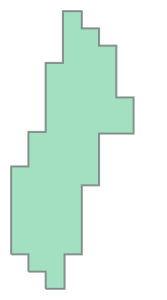

In [100]:
loads(ut_df['SHAPE'][0])

In [101]:
sh_df['geometry'] = [loads(s) for s in sh_df['SHAPE']]
ut_df['geometry'] = [loads(s) for s in ut_df['SHAPE']]

In [102]:
epsg = 32633
sh_gdf = gpd.GeoDataFrame(sh_df, crs={'init' :'epsg:' + str(epsg)})
ut_gdf = gpd.GeoDataFrame(ut_df, crs={'init' :'epsg:' + str(epsg)})
gdf

,skredID,registrertDato,regStatus,registrertAv,registrertAvBrukerID,endretDato,endretAv,endretAvBrukerID,rettighetsID,SHAPE,geometry
0,E3D86382-F1FB-44B6-AC92-06478C56E11F,2020-02-03 16:15:04.0000000,Godkjent kvalitet B,Sentinel-1,131@Sentinel 1,2020-02-03 16:15:04.0000000,Sentinel-1,131@Sentinel 1,1,"POLYGON ((706429.999942176 7686248.9996411577,...","POLYGON ((706430.000 7686249.000, 706449.000 7..."
1,221DBD85-11A1-4F01-9FF8-A3BA2E0E43D8,2020-02-03 16:15:04.0000000,Godkjent kvalitet B,Sentinel-1,131@Sentinel 1,2020-02-03 16:15:04.0000000,Sentinel-1,131@Sentinel 1,1,POLYGON ((704069.99994820356 7685088.999676331...,"POLYGON ((704070.000 7685089.000, 704089.000 7..."
2,4E7EB269-0FB1-4EAB-BF0E-883F9977CCAE,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((33090.005569873378 6732708.976058581...,"POLYGON ((33090.006 6732708.976, 33169.006 673..."
3,A62CE1C7-D005-451D-B185-F5963C1CB9B1,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((32890.005590817891 6732668.975977879...,"POLYGON ((32890.006 6732668.976, 32909.006 673..."
4,C2C8DF82-70B4-4C33-BBA7-B7FF2D59AC42,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((31910.005731143989 6735028.975443072...,"POLYGON ((31910.006 6735028.975, 31969.006 673..."
5,C1F14C1E-847E-41FB-B3CB-6CDB6C278F78,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((28830.006053589284 6733328.974205264...,"POLYGON ((28830.006 6733328.974, 28870.006 673..."
6,D500E9BD-CE7B-4D27-88BC-8EC4BC5BF9FB,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((8570.0089102610946 6736488.963530553...,"POLYGON ((8570.009 6736488.964, 8589.009 67364..."
7,E261708C-1428-4A54-B2CC-B6615CDE49A6,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,"POLYGON ((14310.00800942257 6736108.96685439, ...","POLYGON ((14310.008 6736108.967, 14349.008 673..."
8,89E9984B-39E7-4C6E-B3EE-6156BD58C14C,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((15690.007822397165 6736888.967551194...,"POLYGON ((15690.008 6736888.968, 15749.008 673..."
9,973F64AB-43D3-4BCA-9C62-1ECA288FFD25,2020-02-02 05:54:58.0000000,Godkjent kvalitet B,Sentinel-1,110@Sentinel 1,2020-02-02 05:54:58.0000000,Sentinel-1,110@Sentinel 1,1,POLYGON ((42350.004739175551 6740168.979295468...,"POLYGON ((42350.005 6740168.979, 42369.005 674..."


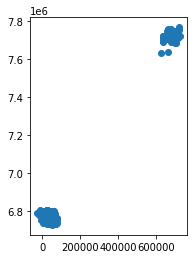

In [103]:
fig, ax = plt.subplots(1, 1)

sh_gdf.plot(ax=ax, legend=True)

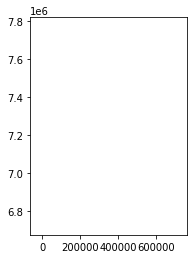

In [104]:
ut_gdf.plot()

In [105]:
# minx, miny, maxx, maxy = gdf.bounds[0]
# geodataframe to lat/lon EPSG:3857
ll_sh = sh_gdf.copy()
ll_sh.to_crs({'init': 'EPSG:3857'}, inplace=True)
ll_ut = ut_gdf.copy()
ll_ut.to_crs({'init': 'EPSG:3857'}, inplace=True)
b = ll_ut.bounds
min(b['minx'])

589921.3946927083

In [107]:
b = ll_ut.bounds
mx = min(b['minx']) + (max(b['maxx'])-min(b['minx']))/2
mx = min(b['miny']) + (max(b['maxy'])-min(b['miny']))/2

ava_map = folium.Map(prefer_canvas=True,
                location = [69, 20], 
                zoom_start = 10)
m = folium.GeoJson(ll_sh)
a = folium.GeoJson(ll_ut,
                  style_function=lambda feature: {
        'fillColor': 'red',
#         'color' : feature['properties']['RGBA'],
        'color': 'red', 'weight' : 1,
        'fillOpacity' : 0.5,
#         'popup': '{0}'.format(feature['properties']['regStatus'])
        'tooltip': 'Click me!'
        })

m.add_to(ava_map)
a.add_to(ava_map)

ava_map

In [11]:
# Plot on leaflet map

incidents_accident = folium.map.FeatureGroup()
latitudes = list(df.LAT)
longitudes = list(df.LON)
labels = list(df.EVENT_TYPE)

ava_map = folium.Map(
                location = [lat, longitude], 
                zoom_start = 10)

for lat, lng, label in zip(latitudes, longitudes, labels):
  if label == 'accident':
    folium.Marker(
      location = [lat, lng], 
      popup = label,
      icon = folium.Icon(color='red', icon='info-sign')
     ).add_to(ava_map) 
  else:
    folium.Marker(
      location = [lat, lng], 
      popup = label,
      icon = folium.Icon(color='green', icon='info-sign')
     ).add_to(ava_map)
    
ava_map.add_child(incidents_accident)
ava_map

AttributeError: 'DataFrame' object has no attribute 'LAT'